In [45]:
import numpy as np
import h5py
from skimage import io, transform, morphology
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.neural_network as classifier
import sklearn.metrics as stat
import sklearn
import matplotlib.pyplot as plt
from rich.jupyter import print
%matplotlib widget

import masking
import core

In [14]:
al = io.imread("Slice0_CoNi16/TPS_out.tif", as_gray=True)
bse = io.imread("Slice0_CoNi16/coni16_459.tif", as_gray=True)
print(al.shape, bse.shape)
print(al.dtype, bse.dtype)

(2048, 3072)
(2048, 3072)

uint8 float64

In [15]:
defects,mask = masking.create_ped_mask(bse)
mask = morphology.binary_erosion(mask, np.ones((100,100)))
al[(mask == 0)] = 0
avg = al[mask].mean()
print("Average value: ", avg)
selection = al > avg*3

Average value:  6.9057554497290985

In [16]:
y_true = selection.reshape(-1)
x = bse.reshape(-1, 1)
x_coord, y_coord = np.meshgrid(np.arange(bse.shape[1]), np.arange(bse.shape[0]))
x_coord = x_coord.reshape(-1, 1)
y_coord = y_coord.reshape(-1, 1)
x_data = x.reshape(-1, 1)
x_data = np.hstack((x, x_coord, y_coord))
print(x_data.shape)

(6291456, 3)

In [43]:
model = make_pipeline(StandardScaler(), classifier.MLPClassifier((50,), solver="adam", random_state=1))
model.fit(x_data, y_true)
print("Fit")
y_pred = model.predict(x_data)
print("Predicted")

Fit

Predicted

0.7198780276370252

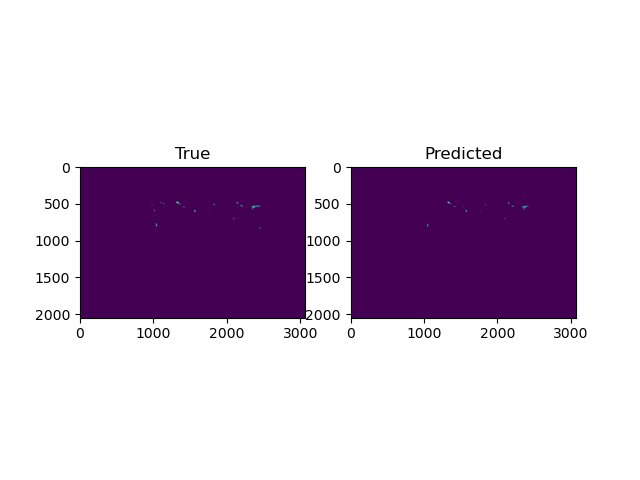

In [49]:

p = stat.balanced_accuracy_score(y_true, y_pred)
print(p)
"""
cf = stat.confusion_matrix(y_true, y_pred)
disp = stat.ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot(cmap="Blues")
plt.show()
"""
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(y_true.reshape(bse.shape))
ax2 = fig.add_subplot(122)
ax2.imshow(y_pred.reshape(bse.shape))
ax1.set_title("True")
ax2.set_title("Predicted")
plt.show()
# """


In [46]:
sklearn.set_config(display="diagram")
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(50,), random_state=1))])

In [ ]:
try:
    h5.close()
except:
    pass
h5 = h5py.File("D:/Research/CoNi_16/Data/3D/test.dream3d", "r+")
align = core.Alignment("Slice420_CoNi16/ctr_pts_bse.txt", "Slice420_CoNi16/ctr_pts_ebsd.txt", "TPS")
align.import_solution("Slice420_CoNi16/TPS_mapping.npy", "Slice420_CoNi16/bse.tif")
cell_str = "DataContainers/ImageDataContainer/CellData"

In [ ]:
for key in h5[cell_str].keys():
    data = h5[cell_str][key][...]
    for i in range(h5[cell_str][key].shape[-1]):
        for z in range(h5[cell_str][key].shape[0]):
            h5[cell_str][key][z,:-1,10:,i] = align.apply(h5[cell_str][key][z,:-1,10:,i], out="array")
            if z%10 == 0:
                print(f"Correcting {key} dimension {i}: {z}/{h5[cell_str][key].shape[0]-1}\r", end="", flush=True)
        print("\n")

In [ ]:
plt.imshow(h5[cell_str]["SEM"][100,:,:,0])
plt.show()

In [ ]:
h5.close()